In [1]:
  """ to load assets from github """
import os
if not os.path.exists("assets"):
    !git clone https://github.com/desmond-rn/assets.git
else:
    print("Data already here. Let's update it!")
    %cd assets
    # %rm -rf assets
    !git pull https://github.com/desmond-rn/assets.git
    %cd ..

!ls assets

Cloning into 'assets'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 98 (delta 23), reused 50 (delta 5), pack-reused 0
Unpacking objects: 100% (98/98), done.
dataframes  README.md


In [2]:
%reset -f

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import sklearn
import random                                               # pour randomiser les donnees train, val, et test si nécessaire 
import assets.dataframes.movie.movie_dico as movie_dico     # les dicos crees dans le notebook precedent

from ast import literal_eval
from keras.datasets import imdb
from sklearn import metrics
from sklearn import datasets

from sklearn import tree
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import neural_network
from sklearn import svm

Using TensorFlow backend.


In [4]:
np.set_printoptions(precision=2)

Ce notebook s'appui sur le travail effectué dans le notebook `nb1_retraitement_et_analyse_de_données.ipynb`. Dans ce dernier notebook, nous avons traité et analysé les données, et nous les avons sauvegardé sur github.

Objectif de ce notebook:

- Predire les genres d'un film  -> apprentissage 1
- Predire le succes d'un film  -> apprentissage 2

Tout ceci a partir de l'intrigue, des motes cles, du budget, etc. tous connus avant la sortie du film.

#I - PREDICTION DU GENRE

On désire prédire le(s) genre(s) d'un film à partir de son intrigue.

## Preparation

### Chargeons les donnees

Pour cette section, nous nous servons de la dataframe imputee (**4800** lignes), celle dans laquelle nous avions remplacé les valeurs (numériques) aberantes par les moyennes. Heureusement, nous n'avons pas besoin de ces valeurs non fiables pour cet apprentissage. 

In [5]:
converters={"genres": literal_eval, "keywords": literal_eval, "spoken_languages":literal_eval, "production_companies":literal_eval, "production_countries":literal_eval}      # on veut convertir les str en listes

df_0 = pd.read_csv("assets/dataframes/movie/tmdb_5000_movies_imputed.csv", thousands=',', converters=converters)

# d'entree, supprimons les colones inutiles, y compris les "dummies" qui nous ont servis dans le notebook precedent
df_1 = df_0.drop(['Unnamed: 0'], axis=1)
for genre in movie_dico.genres_to_id.keys():
  if genre != '<PAD>':
    df_1 = df_1.drop(genre, axis=1)

df_1.head(2)

,id,title,release_date,tagline,overview,keywords,genres,runtime,budget,revenue,return,return_type,popularity,vote_average,vote_count,production_countries,original_language,spoken_languages,production_companies
0,0,Avatar,2009-12-10,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...","[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]",162.0,237.0,2787.965,11.763565,massive success,150.437577,7.2,11800,"[United States of America, United Kingdom]",en,"[English, Español]","[Ingenious Film Partners, Twentieth Century Fo..."
1,1,Pirates of the Caribbean: At World's End,2007-05-19,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha...","[ocean, drug abuse, exotic island, east india ...","[Adventure, Fantasy, Action]",169.0,300.0,961.000,3.203333,massive success,139.082615,6.9,4500,[United States of America],en,[English],"[Walt Disney Pictures, Jerry Bruckheimer Films..."


### Numerisation des donnes

Pour obtenir les donnes nécessaires à l’apprentissage, transformons les intrigues, slogans, et mots clés (chaines de caractères) en liste d'entiers. Utilisons le dictionnaire imdb de Keras pour les mots simples, et nos propres dictionnaires pour les groupes de mots et les noms propres.

In [6]:
""" Utilisons le dict de keras pour les mots simples """
word_to_id = {k:v+2 for (k,v) in imdb.get_word_index().items()}      # on obtient donc 3 places vides reservees, car 0 est naturellement reserve
word_to_id["<PAD>"] = 0           # pour completer les intrigues une fois transformes (tous a une meme taille)
word_to_id["<START>"] = 1         # pour le debut de sequence
word_to_id["<UNK>"] = 2           # pour les mots inconnues

id_to_word = {v:k for (k,v) in word_to_id.items()}                    # son dictionnaire inverse

""" Utilisons nos propres dictionnaires pour les mots cles, les compagnies, les pays et les langues, (groupes de mots) """
genre_to_id = movie_dico.genres_to_id                                 # 0 fut reverve pour le padding
keyword_to_id = movie_dico.keywords_to_id
company_to_id = movie_dico.production_companies_to_id
language_to_id = movie_dico.spoken_languages_to_id
country_to_id = movie_dico.production_countries_to_id

genre_to_id["<PAD>"] = 0
keyword_to_id["<PAD>"] = 0
company_to_id["<PAD>"] = 0
language_to_id["<PAD>"] = 0
country_to_id["<PAD>"] = 0

id_to_genre = {v:k for (k,v) in genre_to_id.items()}
id_to_keyword = {v:k for (k,v) in keyword_to_id.items()}
id_to_company = {v:k for (k,v) in company_to_id.items()}
id_to_language = {v:k for (k,v) in language_to_id.items()}
id_to_country = {v:k for (k,v) in country_to_id.items()}

1646592/1641221 [==============================] - 1s 0us/step


In [7]:
""" Genere des fonctions pour transfromer l'overview ou la tagline """
def transform_1(column):

  def func(line):
    sentence = line[column] 
    if str(sentence) == 'nan':
      return [2]
    else:
      tab = [1]
      for el in sentence.split():
        word = el.lower().replace(',', '').replace('.', '').replace(';', '').replace(':', '')
        tab.append(word_to_id.get(word, 2))
      return tab

  return func

""" Genere des fonctions pour transfromer les mots cles, les compagnuies, les languesm ou les pays """
def transform_2(column):

  def func(line):
    tab = []
    for el in line[column]:
      if column == 'genres':
        tab.append(genre_to_id[el])
      elif column == 'keywords':
        tab.append(keyword_to_id[el])
      elif column == 'production_companies':
        tab.append(company_to_id[el])
      elif column == 'spoken_languages':
        tab.append(language_to_id[el])
      elif column == 'production_countries':
        tab.append(country_to_id[el])
    return tab

  return func

""" On numerise tout ce qui est numerisable """
def numerize_dataframe(df):
  df['overview'] = df.apply(transform_1('overview'), axis=1)
  df['tagline'] = df.apply(transform_1('tagline'), axis=1)

  df['genres'] = df.apply(transform_2('genres'), axis=1)
  df['keywords'] = df.apply(transform_2('keywords'), axis=1)
  df['production_companies'] = df.apply(transform_2('production_companies'), axis=1)
  df['spoken_languages'] = df.apply(transform_2('spoken_languages'), axis=1)
  df['production_countries'] = df.apply(transform_2('production_countries'), axis=1)
  return df

df_1 = numerize_dataframe(df_1)

df_1.head(2)

,id,title,release_date,tagline,overview,keywords,genres,runtime,budget,revenue,return,return_type,popularity,vote_average,vote_count,production_countries,original_language,spoken_languages,production_companies
0,0,Avatar,2009-12-10,"[1, 2540, 3, 181, 6, 38950]","[1, 10, 3, 50823, 1116, 5, 2, 7734, 8, 15876, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4]",162.0,237.0,2787.965,11.763565,massive success,150.437577,7.2,11800,"[1, 2]",en,"[1, 2]","[1, 2, 3, 4]"
1,1,Pirates of the Caribbean: At World's End,2007-05-19,"[1, 32, 3, 129, 6, 3, 181, 3, 1153, 777]","[1, 1704, 2, 195, 2416, 7, 29, 350, 46, 215, 1...","[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","[2, 3, 1]",169.0,300.0,961.000,3.203333,massive success,139.082615,6.9,4500,[1],en,[1],"[5, 6, 7]"


In [8]:
# testons l'overview et la tagline sur le i-eme film 
col = 'overview'
i = 2

original = df_0.loc[i, col]
recomputed = ' '.join([id_to_word[j] for j in df_1.loc[i, col]])

print(df_1.loc[i, 'title'], '('+df_1.loc[i, 'release_date'][:4]+')')
print(col.upper(), "ORIGINAL: ", original)
print(col.upper(), "RETROUVEE: ", recomputed)

Spectre (2015)
OVERVIEW ORIGINAL:  A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE.
OVERVIEW RETROUVEE:  <START> a cryptic message from <UNK> past sends him on a trail to uncover a sinister organization while m battles political forces to keep the secret service alive bond peels back the layers of deceit to reveal the terrible truth behind spectre


### Créons les données train et test

In [9]:
""" Visualisons les entrees et les sorties necessaires """
print("Version originale:")
display(df_0.iloc[:5, [5, 7]])     # version originale
print("\nVersion numerisee:")
df_1.iloc[:5, [4, 6]]     # version numerizee

Version originale:


,overview,genres
0,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]"
1,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]"
2,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]"
3,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]"
4,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]"



Version numerisee:


,overview,genres
0,"[1, 10, 3, 50823, 1116, 5, 2, 7734, 8, 15876, ...","[1, 2, 3, 4]"
1,"[1, 1704, 2, 195, 2416, 7, 29, 350, 46, 215, 1...","[2, 3, 1]"
2,"[1, 5, 14257, 748, 38, 2, 500, 3291, 89, 22, 5...","[1, 2, 5]"
3,"[1, 1044, 3, 340, 6, 7794, 4816, 4354, 23376, ...","[1, 5, 6, 7]"
4,"[1, 307, 3513, 8, 5, 2, 1137, 1247, 1704, 870,...","[1, 2, 4]"


On utilise la methode **one_hot_encoding** pour encoder nos vecteurs. Chaque sequence de mot est transformee en sequence de longueur 'dimension'. 

In [10]:
""" une fonction pour transformer les sequences d'entiers en sequences de longueur diemnsion en prenant en compte la repetition d'un entier dans la sequence """
def vectorize_sequence(sequence, dimension):
  result = np.zeros(dimension, dtype=np.int32)
  for i in sequence:
      result[i] += 1  # ajoute 1 a cet indice
  return result

""" un test """
test = [3,1,1,3]
print("original:  ", test)
print("vectorisee:", vectorize_sequence(test, 10))

original:   [3, 1, 1, 3]
vectorisee: [0 2 0 2 0 0 0 0 0 0]


In [11]:
""" on fait une permutation car dans la dataframe, les films populaires on tendance a se retrouver au debut """
size = len(df_1)
indices = np.arange(size)
# random.shuffle(indices)
shuffle = {i:k for (i, k) in enumerate(indices)}     # un petit dictionnaire pour acceder a la dataframe apres

""" les x """
len_x = len(word_to_id) - 1     # moins le PAD
x = np.empty(shape=(size, len_x), dtype=int)

for (i, i_prime) in shuffle.items():
  x[i] = vectorize_sequence(np.array(df_1.loc[i_prime, 'overview']), len_x)

""" les y """
len_y = len(genre_to_id) - 1
y = np.empty(shape=(size, len_y), dtype=int)

for (i, i_prime) in shuffle.items():
  y[i] = vectorize_sequence(np.array(df_1.loc[i_prime, 'genres'])-1, len_y)

print('x shape =', x.shape)
print('y shape =', y.shape)

x shape = (4800, 88586)
y shape = (4800, 20)


In [12]:
""" visualisons a quoi ressemble les inputs et les outputs juste avant l'apprentissage """
i = 0

print('input :', x[i], '\t\t\t\t', df_0.loc[i, 'overview'])
print('output:', y[i], '\t', df_0.loc[i, 'genres'])

input : [0 1 1 ... 0 0 0] 				 In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.
output: [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 	 ['Action', 'Adventure', 'Fantasy', 'Science Fiction']


In [13]:
""" separons tain, val et test """
def split_data(x, y, len_train, len_val):
  train = len_train
  val = len_train + len_val

  x_train = x[:train]
  x_val = x[train:val]
  x_test = x[val:]

  y_train = y[:train]
  y_val = y[train:val]
  y_test = y[val:]

  return x_train, x_val, x_test, y_train, y_val, y_test

len_train, len_val = 3000, 1000
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y, len_train, len_val)

print("x shapes:", x_train.shape, x_val.shape, x_test.shape)
print("y shapes:", y_train.shape, y_val.shape, y_test.shape)

x shapes: (3000, 88586) (1000, 88586) (800, 88586)
y shapes: (3000, 20) (1000, 20) (800, 20)


## Apprentissage

### Réseau de neuronnes

#### Model

On utilise un réseau de neurones (de la librairie Keras) à deux couches complètement connectées avec une fonction d'activation relu. 

In [14]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(256, 
                            #  kernel_regularizer=keras.regularizers.l2(0.001),
                             activation='relu', 
                             input_shape=(len_x,)))                      # len_x = 88586

# model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Dense(64, 
                            #  kernel_regularizer=keras.regularizers.l2(0.001), 
                             activation='relu'))

# model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Dense(len_y, 
                             activation='sigmoid'))                      # len_y = 20

""" Vérifions les parametres du modele """
model.summary()

print("\nInfos supplémentaires")
for index in [0, 1, 2]:
    print("---------------------------")
    weights, bias = model.layers[index].get_weights()
    print("layer:", index)
    print("weights shape:", weights.shape)
    print("bias shape:", bias.shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               22678272  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1300      
Total params: 22,696,020
Trainable params: 22,696,020
Non-trainable params: 0
_________________________________________________________________

Infos supplémentaires
---------------------------
layer: 0
weights shape: (88586, 256)
bias shape: (256,)
---------------------------
layer: 1
weights shape: (256, 64)
bias shape: (64,)
---------------------------
layer: 2
weights shape: (64, 20)
bias shape: (20,)


Pour la compilation, on utlise:
- l'optimiseur Adam
- la `binary_crossentropy` pour fonction loss
- on observe l'accuracy

In [15]:
model.compile(optimizer=keras.optimizers.Adam(0.001), 
              loss=keras.losses.binary_crossentropy,        # La loss decent un peu plus bas avec la binary crossentropy
              # loss=keras.losses.mse,
              metrics=[keras.metrics.binary_accuracy])

On lance ensuite l'apprentissage sur 15 époques par paquets de 512. On opte pour la méthode d’**early stopping** pour lutter contre le surapprentissage.

In [16]:
history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 3000 samples, validate on 1000 samples
Epoch 1/15
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6635 - binary_accuracy: 0.7144 - val_loss: 0.5958 - val_binary_accuracy: 0.8449
Epoch 2/15
3000/3000 [==============================] - 6s 2ms/step - loss: 0.5371 - binary_accuracy: 0.8581 - val_loss: 0.4539 - val_binary_accuracy: 0.8948
Epoch 3/15
3000/3000 [==============================] - 6s 2ms/step - loss: 0.4135 - binary_accuracy: 0.8741 - val_loss: 0.3646 - val_binary_accuracy: 0.8855
Epoch 4/15
3000/3000 [==============================] - 6s 2ms/step - loss: 0.3524 - binary_accuracy: 0.8705 - val_loss: 0.3297 - val_binary_accuracy: 0.8948
Epoch 5/15
3000/3000 [==============================] - 6s 2ms/step - loss: 0.3193 - binary_accuracy: 0.8871 - val_loss: 0.3216 - val_binary_accuracy: 0.8964
Epoch 6/15
3000/3000 [==============================] - 6s 2ms/step - loss: 0.2914 - binary_accuracy: 0.8926 - val_loss: 0.3141 - val_binary_accuracy: 0.8979
Epoc

Observons la loss et l'accuracy.

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy']) 



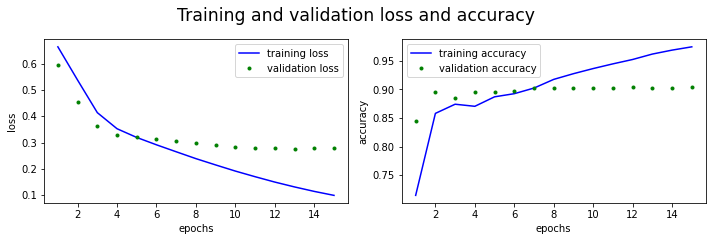

In [17]:
history_dict = history.history
print(history_dict.keys(), '\n')

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

epochs = range(1, len(loss)+1)

fig,(ax0,ax1)=plt.subplots(1,2,figsize=(10, 3))

ax0.plot(epochs, loss, 'b', label='training loss')
ax0.plot(epochs, val_loss, 'g.', label='validation loss')    
ax0.set_xlabel('epochs')
ax0.set_ylabel('loss')
ax0.legend();

ax1.plot(epochs, acc, 'b', label='training accuracy')
ax1.plot(epochs, val_acc, 'g.', label='validation accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.legend();

plt.suptitle("Training and validation loss and accuracy", y=1.1, fontsize='xx-large')
plt.tight_layout()

Bien sur, pas de surapprentissage. On a bien choisi notre nombre d'epochs.

Maintenant faisons, puis observons quelques prédictions. Pour l'instant, on choisi comme seuil `0.5`. On recherchera un meulleiur seuil plus tard. 

In [18]:
hat_y_test_proba = model.predict(x_test)

In [19]:
""" une fonction pour mmieux visulaiser les predictions des genres """
def denumerize(numbers):
  words = []
  for i, nb in enumerate(numbers):
    if nb == 1:
      words.append(id_to_genre[i+1])
  return words

In [20]:
zeros = np.zeros_like(hat_y_test_proba, dtype=int)
ones = np.ones_like(hat_y_test_proba, dtype=int)
hat_y_test = np.where(hat_y_test_proba >= 0.5*ones, ones, zeros)         # on recherchera un meilleur seuil plus tard

def print_prediction(hat_y_test, nb):
  start = len_train + len_val    #indique le debut des donnes test la dataframe
  for i in range(0, size-start, (size-start)//nb):
    print(df_1.loc[shuffle[i+start], 'title'], '('+df_1.loc[shuffle[i+start], 'release_date'][:4]+')')
    print("original:  ", y_test[i], " - ", denumerize(y_test[i]))
    print("prediction:", hat_y_test[i], " - ", denumerize(hat_y_test[i]), "\n")

print_prediction(hat_y_test, 10)

Beer League (2006)
original:   [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]  -  ['Comedy']
prediction: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]  -  ['Comedy'] 

The Lives of Others (2006)
original:   [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  -  ['Drama', 'Thriller']
prediction: [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]  -  ['Action', 'Drama'] 

Buried (2010)
original:   [0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0]  -  ['Drama', 'Thriller', 'Mystery']
prediction: [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  -  ['Action', 'Thriller'] 

Road Hard (2015)
original:   [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]  -  ['Comedy']
prediction: [0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]  -  ['Drama', 'Comedy', 'Romance'] 

Sex With Strangers (2002)
original:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]  -  ['Documentary']
prediction: [0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]  -  ['Drama', 'Comedy', 'Romance'] 

In Her Line of Fire (2006)
original:   [1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  -  ['Action', 'D

On constate que les prédictions sont assez bonnes. Mais le model a l'air d'avoir peur de se tromper, et ne donne très souvent aucune prédiction. La figure 20 confirme bien cela. On résoudra ce problème en ajustant le seuillage dans la suite.

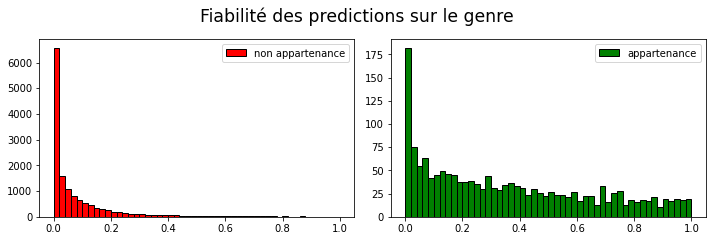

In [21]:
""" Confiance en ses predictions """
fig,(ax0,ax1)=plt.subplots(1,2,figsize=(10,3))
ax0.hist(hat_y_test_proba[y_test==0], bins=50, edgecolor="k", label="non appartenance", color='r')
ax1.hist(hat_y_test_proba[y_test==1], bins=50, edgecolor="k", label="appartenance", color='g');
ax0.legend()
ax1.legend()
plt.suptitle("Fiabilité des predictions sur le genre", y=1.1, fontsize='xx-large')
plt.tight_layout()

Notre modele est tres prudent(LOL). Il est tres sur quand il s'agit de predire a quelle categorie un film n'appartient pas. Par contre, il se trompe la majorite des temps quand il s'agit d'effectivemetn predire les categories auxquelles appartient le film.

In [22]:
""" Calculons le score d'accuracy """
(loss, acc) = model.evaluate(x_test, y_test)
acc

800/800 [==============================] - 1s 1ms/step


0.9038124680519104

In [23]:
""" Confirmons ce score """
acc = len(hat_y_test[hat_y_test == y_test]) / len(y_test.flatten())
print(round(acc, 3))

0.904


90 %, pas mal!

#### Analyse

On veut à présent trouver un seuil meilleur que le 0.5 utilisé jusqu’à présent. Pour cela, calculons la précision et le rappel. On décrète que la classe positive c'est la classe des 1 (pour chacun des 20 genres possibles). C'est de toute évidence la classe minoritaire. 

In [24]:
""" la matrice de confusion """
c_matrix = sklearn.metrics.confusion_matrix(y_test.flatten(), hat_y_test.flatten())

def print_confusion(c_matrix):
  display(pd.DataFrame(data=c_matrix, columns=[ r"^-", r"^+"], index=[r"-", r"+"]))

print_confusion(c_matrix)

,^-,^+
-,13957,417
+,1122,504


In [25]:
def print_score(c_matrix):
  TN = c_matrix[0,0]
  FP = c_matrix[0,1]
  FN = c_matrix[1,0]
  TP = c_matrix[1,1]

  precision = TP / (TP + FP)    # accuracy of the positive predictions
  recall = TP / (TP + FN)       # ratio of positive instances that are correctly detected
  f1 = 2 / (1/precision + 1/recall)

  print("precision = %.2f"%precision)
  print("recall = %.2f"%recall)
  print("\nf1 score = %.2f"%f1)

print_score(c_matrix)

precision = 0.55
recall = 0.31

f1 score = 0.40


Mediocre. On confirme ci-dessous qu'on ne peut avoir a la fois une precision et un rappel eleves.

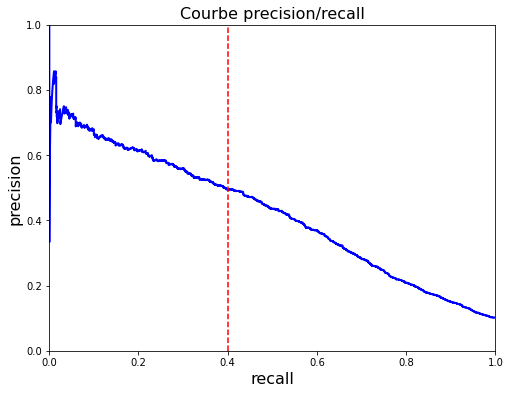

In [26]:
""" courbe recall/precision """
precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(y_test.flatten(), hat_y_test_proba.flatten())
wanted_recall = 0.4         # on desire obtenir une recall de 0.4. Ca me semble un bon compromis

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.plot([wanted_recall, wanted_recall], [0, 1], 'r--')
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.title("Courbe precision/recall", fontsize=16)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

In [27]:
wanted_threshold = thresholds[abs(recalls[:-1]-wanted_recall) <= 5e-4][0]
print("threshold recherchee: %.2f"%wanted_threshold)

threshold recherchee: 0.39


Comme dit plus haut, on ne peut avoir les deux bon au meme moment. Or:
- **precision fort**: on ne selectionne que les vrai positifs.
- **racall fort:** on s'est tres peu trompé sur les FN. Donc on a classe beacoup de données comme positives.  

Ici nous voulons obtenir un fort rappel. Car ce n'est pas grave si notre réseau donne quelques mauvaises prédictions sur le genre, du moment qu'on a au moins une catégorie dans laquelle classer le film. Cependant, la ci-haut montre que la dépendance précision/rappel est loin d’être idéale. Un compromis acceptable entre bonne précision et bon rappel peut être pris tel que rappel=0.4. Qui correspond a un seuil de 0.39.

In [28]:
hat_y_test = np.where(hat_y_test_proba >= wanted_threshold*ones, ones, zeros)

""" les nouveaux scores attendus """
c_matrix = sklearn.metrics.confusion_matrix(y_test.flatten(), hat_y_test.flatten())
print_score(c_matrix)

precision = 0.49
recall = 0.40

f1 score = 0.44


Le f1 score est deja meilleure. C'est bon signe.

In [29]:
""" les nouvelles predictions """
print_prediction(hat_y_test, 10)

Beer League (2006)
original:   [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]  -  ['Comedy']
prediction: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]  -  ['Comedy'] 

The Lives of Others (2006)
original:   [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  -  ['Drama', 'Thriller']
prediction: [1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  -  ['Action', 'Drama', 'Thriller'] 

Buried (2010)
original:   [0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0]  -  ['Drama', 'Thriller', 'Mystery']
prediction: [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  -  ['Action', 'Thriller'] 

Road Hard (2015)
original:   [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]  -  ['Comedy']
prediction: [0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]  -  ['Drama', 'Comedy', 'Romance'] 

Sex With Strangers (2002)
original:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]  -  ['Documentary']
prediction: [0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]  -  ['Drama', 'Comedy', 'Romance'] 

In Her Line of Fire (2006)
original:   [1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  -  [

Cette fois, les prédictions sont bien meilleures que dernièrement. Même quand le model se trompe, la catégorie qu'il indique n'est pas très éloignée de la vraie catégorie, comme nous pouvons l’observer sur la matrice de corrélations.

### Arbres de decisions

#### Model

Vu qu'il s'agit d'une classification multi-label, nous devons utiliser un estimateur qui supporte l’approche **one_vs_all**. On se tourne naturellement vers les arbres de décisions.

In [30]:
""" une fois de plus separons tain et test """
len_train, len_val = 4000, 0            # pas de donnee val cette fois. On fait une cross-validation.
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y, len_train, len_val)

print("x shapes:", x_train.shape, x_val.shape, x_test.shape)
print("y shapes:", y_train.shape, y_val.shape, y_test.shape)

x shapes: (4000, 88586) (0, 88586) (800, 88586)
y shapes: (4000, 20) (0, 20) (800, 20)


In [31]:
""" parametrisation du modele """
tree_model = sklearn.tree.DecisionTreeClassifier(max_depth=None, random_state=42)
# tree_model = sklearn.neural_network.MLPClassifier()
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [32]:
""" faisons quelques predictions """
# hat_y_test_proba = tree_model.predict_proba(x_test)
hat_y_test = tree_model.predict(x_test)
# hat_y_test = np.where(hat_y_test_proba >= 0.5*ones, ones, zeros)

print_prediction(hat_y_test, 10)

Beer League (2006)
original:   [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]  -  ['Comedy']
prediction: [0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]  -  ['Drama', 'Comedy', 'Romance'] 

The Lives of Others (2006)
original:   [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  -  ['Drama', 'Thriller']
prediction: [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]  -  ['Drama', 'Romance'] 

Buried (2010)
original:   [0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0]  -  ['Drama', 'Thriller', 'Mystery']
prediction: [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]  -  ['Drama', 'Romance'] 

Road Hard (2015)
original:   [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]  -  ['Comedy']
prediction: [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]  -  ['Drama', 'Romance'] 

Sex With Strangers (2002)
original:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]  -  ['Documentary']
prediction: [0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]  -  ['Adventure', 'Animation', 'Romance'] 

In Her Line of Fire (2006)
original:   [1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  

Les prédictions ne sont pas vraiment meilleures que les précédentes. En l’occurrence, le model semble fixé sur la dualité 'Drama' - 'Romance'. C’est quand même vrai que les romances demandent beaucoup de drames, assez pour en décourager certains ? :)

#### Analyse

In [33]:
""" Score severe """
acc = tree_model.score(x_test, y_test)
print(round(acc, 3))

0.055


Ce score est vraiment trop sevère. On est quand meme rassuré de savoir que pour 800 x 0.055 = **44 films**, les categories sont exactement celles attendues.

In [34]:
""" Matrice de confusion """
c_matrix = sklearn.metrics.confusion_matrix(y_test.flatten(), hat_y_test.flatten())

print_confusion(c_matrix)
print()
print_score(c_matrix)

,^-,^+
-,13083,1291
+,1070,556



precision = 0.30
recall = 0.34

f1 score = 0.32


Le score F1 confirme bien que ce modèle est moins performant que le réseau de neurones. C'est assez normal, vu que le reseau de neuronne a ete bien plus parametrise que celui ci.

# II - PREDICTION DU SUCCES

On désire prédire le succès/échec d'un film ("return_type") en fonction du **budget** qui est investi, de la **durée** du film, des **genres** de ce film, des **langues** qui y figurent, des **compagnies** de production qu’on embauche pour le produire, et des **mots clés** qui caractérisent le film.


## Preparation

### Cheargeons les donnes

Pour cette section, nous utiliserons la dataframe 2. Bien que moins riche (environ **3211** lignes) que la premeire, toutes ses valeurs numeriques sont fiables. On se servira du Bagging pour remiedier a la petitesse des donnees.

In [35]:
df_0 = pd.read_csv("assets/dataframes/movie/tmdb_5000_movies_omitted.csv", thousands=',', converters=converters)      # pour l'apprentissage 2

# d'entree, supprimons les colones inutiles
df_2 = df_0.drop(['Unnamed: 0'], axis=1)
for genre in genre_to_id.keys():
  if genre != '<PAD>':
    df_2 = df_2.drop(genre, axis=1)

df_2.head(2)

,id,title,release_date,tagline,overview,keywords,genres,runtime,budget,revenue,return,return_type,popularity,vote_average,vote_count,production_countries,original_language,spoken_languages,production_companies
0,0,Avatar,2009-12-10,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...","[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]",162.0,237.0,2787.965,11.763565,massive success,150.437577,7.2,11800,"[United States of America, United Kingdom]",en,"[English, Español]","[Ingenious Film Partners, Twentieth Century Fo..."
1,1,Pirates of the Caribbean: At World's End,2007-05-19,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha...","[ocean, drug abuse, exotic island, east india ...","[Adventure, Fantasy, Action]",169.0,300.0,961.000,3.203333,massive success,139.082615,6.9,4500,[United States of America],en,[English],"[Walt Disney Pictures, Jerry Bruckheimer Films..."


### Numerisons les donnnes

In [36]:
df_2 = numerize_dataframe(df_2)

df_2.head(2)

,id,title,release_date,tagline,overview,keywords,genres,runtime,budget,revenue,return,return_type,popularity,vote_average,vote_count,production_countries,original_language,spoken_languages,production_companies
0,0,Avatar,2009-12-10,"[1, 2540, 3, 181, 6, 38950]","[1, 10, 3, 50823, 1116, 5, 2, 7734, 8, 15876, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4]",162.0,237.0,2787.965,11.763565,massive success,150.437577,7.2,11800,"[1, 2]",en,"[1, 2]","[1, 2, 3, 4]"
1,1,Pirates of the Caribbean: At World's End,2007-05-19,"[1, 32, 3, 129, 6, 3, 181, 3, 1153, 777]","[1, 1704, 2, 195, 2416, 7, 29, 350, 46, 215, 1...","[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","[2, 3, 1]",169.0,300.0,961.000,3.203333,massive success,139.082615,6.9,4500,[1],en,[1],"[5, 6, 7]"


In [37]:
# testons les mots cles, sur le i-eme film 
i = 0

original = df_0.loc[i, 'keywords']
recomputed = ', '.join([id_to_keyword[j] for j in df_2.loc[i, 'keywords']])

print(df_2.loc[i, 'title'], ':', df_2.loc[i, 'release_date'])
print("MOTS CLES ORIGINAUX: ", original)
print("MOTS CLES RETROUVES: ", recomputed)

Avatar : 2009-12-10
MOTS CLES ORIGINAUX:  ['culture clash', 'future', 'space war', 'space colony', 'society', 'space travel', 'futuristic', 'romance', 'space', 'alien', 'tribe', 'alien planet', 'cgi', 'marine', 'soldier', 'battle', 'love affair', 'anti war', 'power relations', 'mind and soul', '3d']
MOTS CLES RETROUVES:  culture clash, future, space war, space colony, society, space travel, futuristic, romance, space, alien, tribe, alien planet, cgi, marine, soldier, battle, love affair, anti war, power relations, mind and soul, 3d


### Creons les donnees train, val et test



---


On anticipe, on sait qu'on veut tester le modèle sur des donnees qui sont equilibrées. C'est a dire autant de 'succes' que de 'failure' que de 'massive succes'. On place donc assez de 'failures' et de 'massive succes' a la fin de la dataframe.  

---

En fin de compte, ce n'est pas interressant de la faire! En effet, lorsque la reapartition des donnes sur lesquels on teste est drastiquement differente de la repartition des donnes d'entrainement, les scores mesures sont tres faibles. 


In [38]:
""" on fait dabord une permutation totale complete de la dataframe """
size = len(df_2)
indices = np.arange(size)
# random.shuffle(indices)

######################################
# """ placons "number" elements de type "type" a la fin de la df, a partir de "from" """
# def put_back(type, number, start_at):
#   counter = 0
#   i = 0
#   while i < size and counter < number:
#     if df_2.loc[i, 'return_type'] == type:
#       tmp = indices[i]
#       indices[i] = indices[start_at-counter]
#       indices[start_at-counter] = tmp
#       counter += 1
#     i += 1

# len_test = 450
# len_each = len_test//3
# put_back("massive success", len_each, size-1)
# put_back("failure", len_each, size-1 - len_each)
# put_back("success", len_test//3, size-1 - 2*len_each)
########################################

shuffle = {k:i for (i, k) in enumerate(indices)}     # un petit dictionnaire pour recapituler et acceder a la dataframe apres

########################################
# """ un test, les 10 derniers doivent etres des 'massive success' """
# for i in list(shuffle.keys())[-10:]:
#   print(df_2.loc[i, 'return_type'])
########################################

In [39]:
""" Visualisons les entrees et les sorties necessaires """
display(df_0.iloc[:5, [9, 8, 7, 18, 19, 6, 12]])
print()
df_2.iloc[:5, [8, 7, 6, 17, 18, 5, 11]]

,budget,runtime,genres,spoken_languages,production_companies,keywords,return_type
0,237.0,162.0,"[Action, Adventure, Fantasy, Science Fiction]","[English, Español]","[Ingenious Film Partners, Twentieth Century Fo...","[culture clash, future, space war, space colon...",massive success
1,300.0,169.0,"[Adventure, Fantasy, Action]",[English],"[Walt Disney Pictures, Jerry Bruckheimer Films...","[ocean, drug abuse, exotic island, east india ...",massive success
2,245.0,148.0,"[Action, Adventure, Crime]","[Français, English, Español, Italiano, Deutsch]","[Columbia Pictures, Danjaq, B24]","[spy, based on novel, secret agent, sequel, mi...",massive success
3,250.0,165.0,"[Action, Crime, Drama, Thriller]",[English],"[Legendary Pictures, Warner Bros., DC Entertai...","[dc comics, crime fighter, terrorist, secret i...",massive success
4,260.0,132.0,"[Action, Adventure, Science Fiction]",[English],[Walt Disney Pictures],"[based on novel, mars, medallion, space travel...",failure


,budget,runtime,genres,spoken_languages,production_companies,keywords,return_type
0,237.0,162.0,"[1, 2, 3, 4]","[1, 2]","[1, 2, 3, 4]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",massive success
1,300.0,169.0,"[2, 3, 1]",[1],"[5, 6, 7]","[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...",massive success
2,245.0,148.0,"[1, 2, 5]","[3, 1, 2, 4, 5]","[8, 9, 10]","[38, 39, 40, 41, 42, 43, 44]",massive success
3,250.0,165.0,"[1, 5, 6, 7]",[1],"[11, 12, 13, 14]","[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5...",massive success
4,260.0,132.0,"[1, 2, 4]",[1],[5],"[39, 66, 67, 6, 68, 10, 69, 70, 71, 72, 73, 74...",failure


Un vecteur d'entree $x_i$ est juste la concatenation de:
- La forme normalisée du budget  $\frac{budget \ du \ film \ i}{maximum \ des \ budgets}$ (de longeur $1$)
- La forme normalisée de la durée 
- La forme vectorisée des genres  (de longeur $20$)   
- La forme vectorisée des langues (de longueur 62)
- La forme vectorisée des compagnies de production (de longueur 5017)  
- La forme vectorisée des mots clés (de longueur 9813)

Ce qui nous donne une longeur totale de $14914$. 

Un scalaire $y_i$ vaut :
- 	0 pour la classe "failure"
- 	1 pour la classe "success"
- 	2 pour la classe "massive success"

Implementons tout cela.

In [40]:
""" les x """
len_b, max_b = 1, max(df_2['budget'])     # max_b servira pour normaliser des budgets entre 0 et 1
len_r, max_r = 1, max(df_2['runtime'])
len_g = len(genre_to_id) - 1
len_l = len(language_to_id) - 1
len_c = len(company_to_id) - 1
len_k = len(keyword_to_id) - 1

x_b = np.empty(shape=(size,), dtype=float)
x_r = np.empty(shape=(size,), dtype=float)
x_g = np.empty(shape=(size, len_g), dtype=float)
x_l = np.empty(shape=(size, len_l), dtype=float)
x_c = np.empty(shape=(size, len_c), dtype=float)
x_k = np.empty(shape=(size, len_k), dtype=float)

for (i, i_prime) in shuffle.items():
  x_b[i] = np.array([df_2.loc[i_prime, 'budget']]) / max_b                                     # juste pour ajouter des 0 et completer la taille
  x_r[i] = np.array([df_2.loc[i_prime, 'runtime']]) / max_r
  x_g[i] = vectorize_sequence(np.array(df_2.loc[i_prime, 'genres']), len_g)
  x_l[i] = vectorize_sequence(np.array(df_2.loc[i_prime, 'spoken_languages']), len_l)
  x_c[i] = vectorize_sequence(np.array(df_2.loc[i_prime, 'production_companies']), len_c)
  x_k[i] = vectorize_sequence(np.array(df_2.loc[i_prime, 'keywords']), len_k)

len_final_x = len_b + len_r + len_g + len_l + len_c + len_k        # la longeur finale d'un vecteur input d'entree
# len_final_x = len_b + len_g + len_l
x = np.empty(shape=(size, len_final_x), dtype=float)

for i in range(size):
  x[i] = np.concatenate((x_b[i], x_r[i], x_g[i], x_l[i], x_c[i], x_k[i]), axis=None)
  # x[i] = np.concatenate((x_b[i], x_g[i], x_l[i]), axis=None)      # pour reduire le nombre d'inputs au cas ou

#############################
# var_per_x = 5       # budget, mot cle, etc..
# max_len_x = max(len_g, len_l, len_c, len_k)        # la plus grande des longeurs
# shape_x = (var_per_x, max_len_x)        # chaque tenseur d'entree a cette forme
# x = np.empty(shape=(size, shape_x[0], shape_x[1]), dtype=float)       # total des features 

# for (i, i_prime) in shuffle.items():
#   x[i][0] = np.array([df_2.loc[i_prime, 'budget']] + [0]*(shape_x[1]-1)) / max_b                                        # juste pour ajouter des 0 et completer la taille
#   x[i][1] = vectorize_sequence(np.array(df_2.loc[i_prime, 'genres']), shape_x[1])
#   x[i][2] = vectorize_sequence(np.array(df_2.loc[i_prime, 'spoken_languages']), shape_x[1])
#   x[i][3] = vectorize_sequence(np.array(df_2.loc[i_prime, 'production_companies']), shape_x[1])
#   x[i][4] = vectorize_sequence(np.array(df_2.loc[i_prime, 'keywords']), shape_x[1])
#############################

""" les y """
target_to_id = {'failure':0, 'success':1, 'massive success':2}                 # un petit dictionnaire pour les labels
id_to_target = {v:k for (k, v) in target_to_id.items()}

y = np.empty(shape=(size,), dtype=int)

for (i, i_prime) in shuffle.items():
  y[i] = target_to_id[df_2.loc[i_prime, 'return_type']]

# print(len_b , len_g , len_l , len_c ,len_k)
print('x shape =', x.shape)
print('y shape =', y.shape)

x shape = (3211, 14914)
y shape = (3211,)


In [41]:
""" visualisons a quoi ressemble les inputs et les outputs juste avant l'apprentissage """
i = 0

print('input :', x[i])
print()
print('output:', y[i])

input : [0.62 0.48 0.   ... 0.   0.   0.  ]

output: 2


In [42]:
""" enfin separons tain et test """
len_train, len_val = 2800, 0
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y, len_train, len_val)

print("x shapes:", x_train.shape, x_val.shape, x_test.shape)
print("y shapes:", y_train.shape, y_val.shape, y_test.shape)

x shapes: (2800, 14914) (0, 14914) (411, 14914)
y shapes: (2800,) (0,) (411,)


In [43]:
########################################
# """ verifions bien que les labels sont equilibres """
# print(y_test)
########################################

## Apprentissage

Il s'agit d'un apprentissage multiclasses. Nous allons essayer plusieurs "bons" models individuellment, et puis nous allons les grouper ensemble pour former un model qu'on espère sera meilleur. Pour ce faire, nous utiliserons exclusivement la librarie ScikitLearn.

### Reseau de neuronnes

#### Model

Jusqu'a present les reseaux de neuronnes se sont montrés efficaces. Heuresement ScikitLearn propose une implementtation pour les reseaux de neuronnes. En plus c'est très facile de preciser les couches intermédiares. 

In [44]:
# model_3 = sklearn.linear_model.SGDClassifier(random_state=42, tol=1e-3, max_iter=5000)
model_3 = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 10), early_stopping=True)

model_3.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [45]:
hat_y_test = model_3.predict(x_test)

In [46]:
""" faisons des predictions """
def prediction(hat_y_test, nb):
  start = len_train + len_val    #indique le debut des donnes test la dataframe

  index = np.arange(start, size, (size-start)//nb)
  index_prime = []

  df = df_0.iloc[:, [2, 3, 12]].copy()
  # df = df_0.iloc[:, [2, 3, 9, 7, 18, 19, 6, 12]].copy()
  # df = df_2.iloc[:, [1, 2, 8, 6, 17, 18, 5, 11]].copy()
  df['prediction'] = 0    # creons juste une nouvelle colonne 

  for i in index:
    df.loc[shuffle[i], 'prediction'] = id_to_target[hat_y_test[i-start]]
    index_prime.append(shuffle[i]) 

  display(df.iloc[index_prime, :])

In [47]:
prediction(hat_y_test, 10)

,title,release_date,return_type,prediction
2800,The Visit,2015-09-10,massive success,success
2841,The Last Exorcism Part II,2013-02-28,success,success
2882,The Nun's Story,1959-06-18,success,success
2923,The Apartment,1960-06-15,success,success
2964,Timecrimes,2007-09-20,failure,failure
3005,Thirteen,2003-08-20,success,success
3046,From Here to Eternity,1953-08-04,massive success,failure
3087,From a Whisper to a Scream,1987-09-25,success,success
3128,Ruby in Paradise,1993-10-08,success,failure
3169,Tupac: Resurrection,2003-01-23,massive success,success


#### Analyse

On dessine la matrice de confusion.

In [48]:
"""  Une fonction pour afficher """
def plot_conf(y_test, hat_y_test):
  print(str(id_to_target)[1:-1])    # afficahge de la legende
  print()

  c_matrix = sklearn.metrics.confusion_matrix(y_test, hat_y_test)
  # sums = c_matrix.sum(axis=1, keepdims=True)
  # norm_c_matrix = c_matrix / sums

  fig, ax = plt.subplots(1, 1)
  img = ax.matshow(c_matrix);
  plt.colorbar(img)
  xlabels = ['^'+str(x) for x in range(3)]
  ax.set_xticklabels(['']+xlabels)

0: 'failure', 1: 'success', 2: 'massive success'



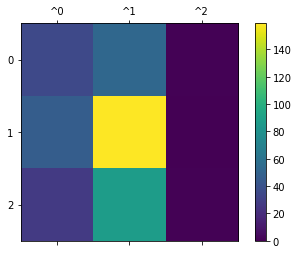

In [49]:
plot_conf(y_test, hat_y_test)

On calcule les scores. Le f1 score par sommation des score sur chaque categorie ponderes par le nombre d'instaces positives (TP) pour chaque classes.

In [50]:
""" calcul des scores """
def print_scores(y_test, hat_y_test, title):
  print(title)

  f1 = sklearn.metrics.f1_score(y_test, hat_y_test, average='weighted')
  print(" - f1 score: %.4f"%f1)

  acc = np.mean(hat_y_test == y_test)
  # acc = sklearn.metrics.accuracy_score(y_test, hat_y_test)
  print(" - accuracy: %.4f"%acc)

In [51]:
print_scores(y_test, hat_y_test, "RESEAU DE NEURONES")

RESEAU DE NEURONES
 - f1 score: 0.3963
 - accuracy: 0.4745


On voit que le modèle prédit bien les succès, probablement parce qu'il y a beaucoup plus de films labélisées "success" dans nos données.

### Regression Logistique

#### Model

In [52]:
model_4 = sklearn.linear_model.LogisticRegression(random_state=42, max_iter=1000)

model_4.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
hat_y_test = model_4.predict(x_test)

In [54]:
prediction(hat_y_test, 10)

,title,release_date,return_type,prediction
2800,The Visit,2015-09-10,massive success,success
2841,The Last Exorcism Part II,2013-02-28,success,success
2882,The Nun's Story,1959-06-18,success,success
2923,The Apartment,1960-06-15,success,success
2964,Timecrimes,2007-09-20,failure,failure
3005,Thirteen,2003-08-20,success,success
3046,From Here to Eternity,1953-08-04,massive success,failure
3087,From a Whisper to a Scream,1987-09-25,success,success
3128,Ruby in Paradise,1993-10-08,success,failure
3169,Tupac: Resurrection,2003-01-23,massive success,success


#### Analyse

0: 'failure', 1: 'success', 2: 'massive success'



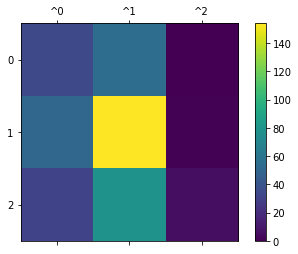

In [55]:
plot_conf(y_test, hat_y_test)

In [56]:
print_scores(y_test, hat_y_test, "REGRESSION LOGISTIQUE")

REGRESSION LOGISTIQUE
 - f1 score: 0.4119
 - accuracy: 0.4720


### Foret Aleatoire

#### Model

In [57]:
# model_5 = sklearn.ensemble.RandomForestClassifier(random_state=42)
model_5 = sklearn.ensemble.RandomForestClassifier(n_estimators=500, max_leaf_nodes=None, n_jobs=-1, random_state=42)

model_5.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [58]:
hat_y_test = model_5.predict(x_test)

In [59]:
prediction(hat_y_test, 10)

,title,release_date,return_type,prediction
2800,The Visit,2015-09-10,massive success,success
2841,The Last Exorcism Part II,2013-02-28,success,success
2882,The Nun's Story,1959-06-18,success,success
2923,The Apartment,1960-06-15,success,success
2964,Timecrimes,2007-09-20,failure,failure
3005,Thirteen,2003-08-20,success,success
3046,From Here to Eternity,1953-08-04,massive success,success
3087,From a Whisper to a Scream,1987-09-25,success,success
3128,Ruby in Paradise,1993-10-08,success,failure
3169,Tupac: Resurrection,2003-01-23,massive success,success


#### Analyse

0: 'failure', 1: 'success', 2: 'massive success'



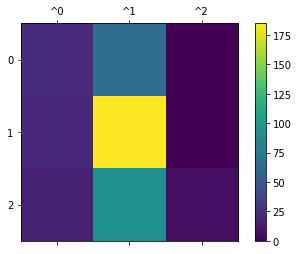

In [60]:
plot_conf(y_test, hat_y_test)

In [61]:
print_scores(y_test, hat_y_test, "FORET ALEATOIRE")

FORET ALEATOIRE
 - f1 score: 0.4362
 - accuracy: 0.5231


Il s’agit-là de notre meilleur score jusqu'à présent. Est-ce qu’on peut faire mieux ?

### Ensemble Learning

#### Model

Essayons de combiner tous nos modeles dans un Soft Voting Clasifier et observons.

In [62]:
model_6 = sklearn.ensemble.VotingClassifier(estimators=[('nn', model_3), ('lr', model_4), ('rf', model_5)], voting='soft')

model_6.fit(x_train, y_train)

VotingClassifier(estimators=[('nn',
                              MLPClassifier(activation='relu', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=True,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(100, 10),
                                            learning_rate='constant',
                                            learning_rate_init=0.001,
                                            max_fun=15000, max_iter=200,
                                            momentum=0.9, n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=None,
                                            sh...
                                                     criterion='gini',
                                          

In [63]:
hat_y_test = model_6.predict(x_test)

In [64]:
prediction(hat_y_test, 10)

,title,release_date,return_type,prediction
2800,The Visit,2015-09-10,massive success,success
2841,The Last Exorcism Part II,2013-02-28,success,success
2882,The Nun's Story,1959-06-18,success,success
2923,The Apartment,1960-06-15,success,success
2964,Timecrimes,2007-09-20,failure,failure
3005,Thirteen,2003-08-20,success,success
3046,From Here to Eternity,1953-08-04,massive success,failure
3087,From a Whisper to a Scream,1987-09-25,success,success
3128,Ruby in Paradise,1993-10-08,success,failure
3169,Tupac: Resurrection,2003-01-23,massive success,success


#### Analyse

0: 'failure', 1: 'success', 2: 'massive success'



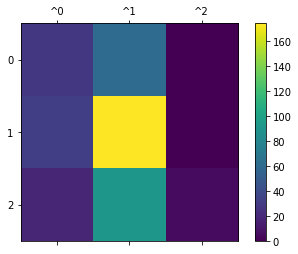

In [65]:
plot_conf(y_test, hat_y_test)

In [66]:
print_scores(y_test, hat_y_test, "ENSEMBLE LEARNING")

ENSEMBLE LEARNING
 - f1 score: 0.4228
 - accuracy: 0.5036


Pas de chance, le modèle est moins performant que le meilleur de ses composants (la foret aléatoire).

### Bagging

Nous avons à notre disposition très peu de données (3200 éléments environ), on fait du Bagging pour remédier à cela. La forêt aléatoire nous a donné le meilleur résultat jusqu’à présent ; utilisons-la ici :

#### Model

In [67]:
model_7 = sklearn.ensemble.BaggingClassifier(
    model_5,
    n_estimators=100,
    max_samples=10, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42)

model_7.fit(x_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
     

In [68]:
hat_y_test = model_7.predict(x_test)

In [69]:
prediction(hat_y_test, 10)

,title,release_date,return_type,prediction
2800,The Visit,2015-09-10,massive success,success
2841,The Last Exorcism Part II,2013-02-28,success,success
2882,The Nun's Story,1959-06-18,success,success
2923,The Apartment,1960-06-15,success,success
2964,Timecrimes,2007-09-20,failure,success
3005,Thirteen,2003-08-20,success,success
3046,From Here to Eternity,1953-08-04,massive success,success
3087,From a Whisper to a Scream,1987-09-25,success,success
3128,Ruby in Paradise,1993-10-08,success,success
3169,Tupac: Resurrection,2003-01-23,massive success,success


#### Analyse

0: 'failure', 1: 'success', 2: 'massive success'



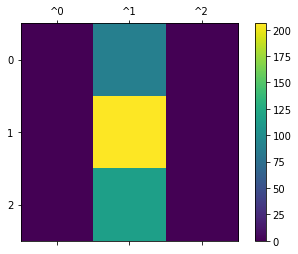

In [70]:
plot_conf(y_test, hat_y_test)

In [71]:
print_scores(y_test, hat_y_test, "BAGGING CLASSIFIER")

BAGGING CLASSIFIER
 - f1 score: 0.3347
 - accuracy: 0.5012


C’est avec tristesse qu’on remarque qu’il reste moins performant que la forêt qui le compose.

## Conclusion sur l'etude du succes

En conclusion, on a du mal à prédire le succès avec plus de 50% d'exactitude (ce qui représente à mon avis le minimum de crédibilité). **D'une part** je suis fautif car je suis un peu stricte dans la catégorisation des succès/échecs. Par exemple, un succès massif prédit comme un simple succès est tout à fait acceptable. J'encouragerais avec enthousiasme la production d'un tel film.

**D'autre part** mon jeu de données n’est pas parfait :
- On a très peu de données : 3200 films, c'est assez petit pour se faire une idée des goûts cinématographiques de l'humanité.
- Ces données ne sont pas assez diversifiées. Il y a beaucoup trop de succès pour très peu d'échecs. Peut-être que, dans quelques années, une métrique universelle de définition du succès sera créée. En plus on aura plus de films à étudier. Ça sera potentiellement plus facile de conduire une telle étude.
- Le succès d'un film dépend énormément des stars à l'affiche. Ça aurait donc été intéressant d'étudier le jeu de données contenant l’équipe de tournage.

**Une autre explication** est que ces faibles scores sont juste naturels. La nature contrôle tout et je n'y peux rien. Si la prédiction du succès d'un film était facile (voire possible) alors tout le monde rentrerait dans l'industrie du cinéma pour se faire riche ; et il n'y aurait plus de data scientist. Je ne veux pas ça :) !!


# III - PERPECTIVES

Nous avons prédit les genres des films, et leur succès grâce à des données toutes connues avant la sortie du film. Les résultats obtenus pour la prédiction des genres sont encourageants. Le réseau de neurones construit peut être adapté pour la création d’un système de recommandation de films. 

En ce qui concerne la prédiction du succès, nous avons obtenu moins de réussite. Nous aurions pu faire une analyse en composante principale pour déterminer quelles variables contribuent le plus au succès. Cela aurait probablement améliorer nos résultats. Nous aurions pu ajouter à tout cela la prédiction de la note moyenne du film, et/ou la somme d’argent que celui-ci rapportera. Cependant, nous avons déjà une bonne idée de la relation entre nos prédictions et ces dernières grâce à la matrice de corrélations.
